In [1]:
import os
import numpy as np
import pandas as pd
import json
import re
import vsmlib
import dask.bag as db
import kmedoids
from IPython.display import display
from nltk.tag.stanford import StanfordPOSTagger as posTagger
from sklearn.manifold import MDS
from matplotlib import pyplot as plt

In [2]:
os.environ['STANFORD_MODELS'] = 'stanford-postagger-2018-02-27/models/english-bidirectional-distsim.tagger'
os.environ['JAVAHOME'] = 'C:\Program Files (x86)\Common Files\Oracle\Java\javapath'

In [3]:
st = posTagger('english-bidirectional-distsim.tagger', path_to_jar='stanford-postagger-2018-02-27/stanford-postagger.jar')

In [4]:
model = vsmlib.model.load_from_dir('word_linear_cbow_50d')
model.normalize()

In [10]:
reviews = db.read_text('yelp-dataset/yelp_academic_dataset_review.json').map(json.loads)
businessData = db.read_text('yelp-dataset/yelp_academic_dataset_business.json').map(json.loads)

In [22]:
reviews.count().compute()

5996996

In [23]:
businessData.count().compute()

188593

In [11]:
data = reviews.take(100)

In [12]:
dataFrame = pd.DataFrame(list(data))
dataFrame.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,iCQpiavjjPzJ5_3gPD5Ebg,0,2011-02-25,0,x7mDIiDB3jEiPGPHOmDzyw,2,The pizza was okay. Not the best I've had. I p...,0,msQe1u7Z_XuqjGoqhB0J5g
1,pomGBqfbxcqPv14c3XH-ZQ,0,2012-11-13,0,dDl8zu1vWPdKGihJrwQbpw,5,I love this place! My fiance And I go here atl...,0,msQe1u7Z_XuqjGoqhB0J5g
2,jtQARsP6P-LbkyjbO1qNGg,1,2014-10-23,1,LZp4UX5zK3e-c5ZGSeo3kA,1,Terrible. Dry corn bread. Rib tips were all fa...,3,msQe1u7Z_XuqjGoqhB0J5g
3,elqbBhBfElMNSrjFqW3now,0,2011-02-25,0,Er4NBWCmCD4nM8_p1GRdow,2,Back in 2005-2007 this place was my FAVORITE t...,2,msQe1u7Z_XuqjGoqhB0J5g
4,Ums3gaP2qM3W1XcA5r6SsQ,0,2014-09-05,0,jsDu6QEJHbwP2Blom1PLCA,5,Delicious healthy food. The steak is amazing. ...,0,msQe1u7Z_XuqjGoqhB0J5g


In [13]:
groupedData = dataFrame.groupby('business_id')

In [14]:
reviewDict = dict()
i = 0
for key, group in groupedData:    
    tagged = st.tag(group['text'])    
    print('iteration: {}, business_id: {}'.format(i, key))
    nouns = [noun for noun, pos in tagged if 'NN' in pos]    
    matrix = []
    for noun in nouns:                
        noun = re.search('\w+', noun)
        if noun: 
            noun = noun.group()        
        if model.has_word(noun):
            matrix.append(model.get_row(noun))            
    reviewDict[key] = matrix    
    i += 1

iteration: 0, business_id: -YR7K3rw6VAQ1-MjslvsoQ
iteration: 1, business_id: -bd4BQcl1ekgo7avaFngIw
iteration: 2, business_id: -ed0Yc9on37RoIoG2ZgxBA
iteration: 3, business_id: 00liP5s4IKsq97EH4Cc0Tw
iteration: 4, business_id: 0bjFYstj8USMzEV4ZQldjA
iteration: 5, business_id: 1VKjDpPJdVoiRc8I9f7U9g
iteration: 6, business_id: 3I23nQZ6k6U2G1NKpTpfhA
iteration: 7, business_id: 3Mx4renubPRnjHUw1n2UkA
iteration: 8, business_id: 6D4L8YpkhAh_YwaLmhoMNg
iteration: 9, business_id: 6qDRqHWqf0EeHupSUEBfKg
iteration: 10, business_id: 6tSvz_21BMo3a4GaItwa0g
iteration: 11, business_id: 7AlULGZI1pHt0imODsqdkg
iteration: 12, business_id: 7m1Oa1VYV98UUuo_6i0EZg
iteration: 13, business_id: 7vxm0G4g857HzRqqpeu6bw
iteration: 14, business_id: 7xA6iSP0Ndn08tpBFQtUKA
iteration: 15, business_id: 8-su-O_330PebTOp60RILQ
iteration: 16, business_id: 9E1q2uEMd881wnruicNTUA
iteration: 17, business_id: A2pHOVp0zh7grb1bbZxoBQ
iteration: 18, business_id: AtbXj3Rg1GF6Dj5zu6KCDg
iteration: 19, business_id: AxeQEz3-s9_1T

In [115]:
def lxjOp(A, B):    
    maxProducts = []
    for a in A:
        innerProducts = []
        for b in B:            
            innerProducts.append(np.inner(a, b) / np.linalg.norm(a) * np.linalg.norm(b))
        maxProducts.append(np.max(innerProducts))   
    
    return np.mean(np.array(maxProducts))

In [116]:
def lxjDist(A, B):
    A = np.array(A)
    B = np.array(B)
    return (lxjOp(A, B) + lxjOp(B, A)) / 2

In [117]:
lxjDist(reviewDict.get('elqbBhBfElMNSrjFqW3now'), reviewDict.get('zdE82PiD6wquvjYLyhOJNA'))

0.727904736995697

In [26]:
dim = len(reviewDict.values())
distanceMatrix = np.zeros((dim, dim))

In [27]:
i=0
for value1 in reviewDict.values():    
    j = 0
    for value2 in reviewDict.values():
        if i < j:
            distanceMatrix[i, j] = lxjDist(value1, value2)
            distanceMatrix[j, i] = distanceMatrix[i, j]
        elif i == j:
            distanceMatrix[i, j] = 0
        j = j+1
    i = i+1

In [28]:
businessDf = pd.DataFrame()
i = 0
for businessId in reviewDict.keys():    
    print('iteration: {}'.format(i))
    def filterFunc(x):
        return x['business_id'] == businessId
    businessDf = businessDf.append(list(businessData.filter(filterFunc)))
    i += 1

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

In [29]:
businessDf.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,13637 N Tatum Blvd,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",-YR7K3rw6VAQ1-MjslvsoQ,"Nightlife, Bars, Sports Bars, Restaurants, Sus...",Phoenix,"{'Monday': '10:30-20:30', 'Tuesday': '10:30-20...",1,33.610821,-111.977497,Eastwind Sushi & Grill,,85032,157,3.0,AZ
0,6990 E Shea Blvd,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",-bd4BQcl1ekgo7avaFngIw,"Breakfast & Brunch, Diners, Restaurants",Scottsdale,"{'Monday': '6:30-15:0', 'Tuesday': '6:30-15:0'...",1,33.582508,-111.931220,Eggstasy,,85254,610,3.5,AZ
0,523 Fremont St,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",-ed0Yc9on37RoIoG2ZgxBA,"Beer Gardens, Nightlife, Thai, Restaurants",Las Vegas,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",1,36.168802,-115.139880,Le Thai,Downtown,89101,1590,4.0,NV
0,9051 E Indian Bend Rd,"{'BikeParking': 'True', 'BusinessAcceptsCredit...",00liP5s4IKsq97EH4Cc0Tw,"Food, Coffee & Tea",Scottsdale,"{'Monday': '5:0-21:0', 'Tuesday': '5:0-21:0', ...",1,33.538119,-111.886272,Starbucks,,85250,54,2.0,AZ
0,120 Meyran Ave,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",0bjFYstj8USMzEV4ZQldjA,"Restaurants, Food Trucks, Desserts, Food, Brea...",Pittsburgh,"{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ...",1,40.440708,-79.958625,Redhawk Coffee,Oakland,15213,107,5.0,PA


In [30]:
M, C = kmedoids.kMedoids(distanceMatrix, 4)

In [31]:
businessDf['clusterLabel'] = 'none'
for label in C:
    for point_idx in C[label]:
        businessDf.iloc[point_idx, businessDf.columns.get_loc('clusterLabel')] = label
        #print('label {0}:　point_idx: {1}'.format(label, point_idx))

In [36]:
grouped = businessDf.groupby('clusterLabel')
for name, group in grouped:
    print('Cluster: {}'.format(name))
    display(group)

Cluster: 0


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,clusterLabel
0,9051 E Indian Bend Rd,"{'BikeParking': 'True', 'BusinessAcceptsCredit...",00liP5s4IKsq97EH4Cc0Tw,"Food, Coffee & Tea",Scottsdale,"{'Monday': '5:0-21:0', 'Tuesday': '5:0-21:0', ...",1,33.538119,-111.886272,Starbucks,,85250,54,2.0,AZ,0
0,501 E Green St,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",7AlULGZI1pHt0imODsqdkg,"Sandwiches, Salad, Delis, Fast Food, Soup, Res...",Champaign,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",1,40.110141,-88.231874,Potbelly Sandwich Shop,,61820,35,4.0,IL,0
0,287 King St W,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",7xA6iSP0Ndn08tpBFQtUKA,"Restaurants, Indian",Toronto,"{'Monday': '11:30-22:30', 'Tuesday': '11:30-22...",1,43.646337,-79.389855,Aroma Fine Indian Cuisine,Entertainment District,M5V 1J5,167,3.5,ON,0
0,4623 E Cactus Rd,"{'BikeParking': 'True', 'BusinessAcceptsCredit...",QVYyTgJFz7lcMv31ZmghGg,"Sporting Goods, Shopping",Phoenix,"{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",1,33.598872,-111.981303,Big 5 Sporting Goods,,85032,9,4.0,AZ,0
0,6219 Shawson Drive,None,SpJYus_184M2TdT7t52rIA,"Automotive, Auto Repair",Mississauga,None,1,43.653382,-79.659636,Robinson Automotive,Hanlan,L5T 1E5,3,5.0,ON,0
0,1025 N Avondale Blvd,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",XgRDG9E_WLEbl8S-QUqQkQ,"Fast Food, Burgers, Ice Cream & Frozen Yogurt,...",Avondale,"{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...",1,33.457276,-112.305877,Culver's,,85323,110,4.0,AZ,0
0,"4550 E Cactus Rd, Ste 168",{'GoodForKids': 'True'},ikTlMObBu3aI4xNmE9X4mA,"Cinema, Arts & Entertainment",Phoenix,None,1,33.602187,-111.983609,Picture Show @ Paradise Valley Mall,,85032,63,4.5,AZ,0
0,4707 E Shea Blvd,"{'Ambience': '{'romantic': False, 'intimate': ...",nUaLFTfUqVKMFQonsWBnag,"Restaurants, Food, Bakeries, Grocery, Delis, B...",Phoenix,"{'Monday': '10:0-20:0', 'Tuesday': '10:0-20:0'...",1,33.580882,-111.978891,Fry's,,85028,147,4.0,AZ,0
0,1901 N Prospect Ave,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",nsSfCKW9KDB4COj9bzXApw,"Restaurants, Seafood, American (Traditional)",Champaign,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,40.138428,-88.258628,Red Lobster,,61822,52,3.0,IL,0
0,"7001 N Scottsdale Rd, Ste C-142","{'BikeParking': 'True', 'BusinessAcceptsCredit...",piHAFVLQHEFv67HVyndrkA,"Shopping, Bridal",Scottsdale,"{'Monday': '10:0-18:0', 'Tuesday': '10:0-18:0'...",1,33.539308,-111.922631,Destiny's Bride,,85253,48,4.5,AZ,0


Cluster: 1


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,clusterLabel
0,4301 E University Dr,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",Xg5qEQiB-7L6kGJ5F4K3bQ,"Barbeque, Restaurants",Phoenix,"{'Tuesday': '11:0-16:0', 'Wednesday': '11:0-16...",1,33.421877,-111.989344,Little Miss BBQ,,85034,1746,5.0,AZ,1


Cluster: 2


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,clusterLabel
0,13637 N Tatum Blvd,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",-YR7K3rw6VAQ1-MjslvsoQ,"Nightlife, Bars, Sports Bars, Restaurants, Sus...",Phoenix,"{'Monday': '10:30-20:30', 'Tuesday': '10:30-20...",1,33.610821,-111.977497,Eastwind Sushi & Grill,,85032,157,3.0,AZ,2
0,6990 E Shea Blvd,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",-bd4BQcl1ekgo7avaFngIw,"Breakfast & Brunch, Diners, Restaurants",Scottsdale,"{'Monday': '6:30-15:0', 'Tuesday': '6:30-15:0'...",1,33.582508,-111.931220,Eggstasy,,85254,610,3.5,AZ,2
0,523 Fremont St,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",-ed0Yc9on37RoIoG2ZgxBA,"Beer Gardens, Nightlife, Thai, Restaurants",Las Vegas,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",1,36.168802,-115.139880,Le Thai,Downtown,89101,1590,4.0,NV,2
0,8909 E Indian Bend Rd,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",1VKjDpPJdVoiRc8I9f7U9g,"Sports Bars, Chicken Wings, Restaurants, Ameri...",Scottsdale,None,1,33.538139,-111.889439,Hooters,,85250,98,3.0,AZ,2
0,"1116 S Dobson Rd, Ste 105","{'AcceptsInsurance': 'False', 'BikeParking': '...",3I23nQZ6k6U2G1NKpTpfhA,"Beauty & Spas, Massage",Mesa,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",1,33.394432,-111.875578,Comfort Foot,,85202,37,4.0,AZ,2
0,"Caesars Palace Las Vegas Hotel Casino, 3570 S ...","{'AgesAllowed': '21plus', 'Alcohol': 'full_bar...",3Mx4renubPRnjHUw1n2UkA,"Bars, Dance Clubs, Adult Entertainment, Nightlife",Las Vegas,"{'Tuesday': '22:0-4:0', 'Thursday': '22:0-4:0'...",1,36.117303,-115.174176,OMNIA Nightclub,The Strip,89109,1030,3.0,NV,2
0,7245 E Gold Dust,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",6D4L8YpkhAh_YwaLmhoMNg,"Restaurants, Italian",Scottsdale,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",0,33.577930,-111.925334,Romano's Macaroni Grill,,85258,122,2.5,AZ,2
0,"4001 E Bell Rd, Ste 102","{'Alcohol': 'none', 'Ambience': '{'romantic': ...",7m1Oa1VYV98UUuo_6i0EZg,"American (Traditional), Burgers, Mexican, Rest...",Phoenix,"{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",1,33.639913,-111.995703,Paradise Valley Burger Company,,85032,1131,4.5,AZ,2
0,1431 E Dunlap Ave,"{'BikeParking': 'True', 'BusinessParking': '{'...",8-su-O_330PebTOp60RILQ,"Hiking, Active Life",Phoenix,None,1,33.567609,-112.050889,Phoenix Mountains Preserve,,85028,45,5.0,AZ,2
0,8870 E Indian Bend Rd,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",9E1q2uEMd881wnruicNTUA,"Restaurants, Chicken Wings, Bars, Sports Bars,...",Scottsdale,"{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ...",1,33.538558,-111.890873,Buffalo Wild Wings,,85250,127,2.5,AZ,2


Cluster: 3


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,clusterLabel
0,120 Meyran Ave,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",0bjFYstj8USMzEV4ZQldjA,"Restaurants, Food Trucks, Desserts, Food, Brea...",Pittsburgh,"{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ...",1,40.440708,-79.958625,Redhawk Coffee,Oakland,15213,107,5.0,PA,3
0,"6257 Carolina Commons Dr, Ste 400","{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",6qDRqHWqf0EeHupSUEBfKg,"Restaurants, Chicken Wings, Burgers, Barbeque",Fort Mill,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",1,34.936240,-80.837925,521 BBQ & Grill,,29707,151,4.0,SC,3
0,"3650 S Decatur Blvd, Ste 31","{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",6tSvz_21BMo3a4GaItwa0g,"Nightlife, Japanese, Karaoke, Sushi Bars, Rest...",Las Vegas,"{'Monday': '11:30-0:0', 'Tuesday': '11:30-0:0'...",1,36.123557,-115.207538,Jjanga Japanese Restaurant,Chinatown,89103,1096,4.0,NV,3
0,370 Kennedy Rd S,"{'BusinessAcceptsCreditCards': 'True', 'Busine...",7vxm0G4g857HzRqqpeu6bw,"Hardware Stores, Home Services, Home & Garden,...",Brampton,"{'Monday': '7:0-1:0', 'Tuesday': '7:0-1:0', 'W...",1,43.678409,-79.723565,Lowe's Home Improvement Warehouse,,L6W 4V2,7,4.5,ON,3
0,5244 N 7th St,{'BusinessAcceptsCreditCards': 'True'},AtbXj3Rg1GF6Dj5zu6KCDg,"Automotive, Auto Repair, Car Dealers, Auto Par...",Phoenix,"{'Monday': '7:30-17:30', 'Tuesday': '7:30-17:3...",1,33.514424,-112.065853,German Auto Service,,85014,60,4.5,AZ,3
0,1424 S 3rd St,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",AxeQEz3-s9_1TyIo-G7UQw,"Thai, Restaurants, Barbeque",Las Vegas,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",0,36.153504,-115.151632,Thai Original BBQ Restaurant,Downtown,89104,87,4.0,NV,3
0,27 S Stephanie St,"{'BikeParking': 'True', 'BusinessAcceptsCredit...",EH3yMY64M0AQNpPj3EERWQ,"Active Life, Amusement Parks, Arcades, Venues ...",Henderson,"{'Monday': '14:0-22:0', 'Tuesday': '14:0-22:0'...",0,36.028177,-115.049016,King Putt Mini,,89012,171,4.5,NV,3
0,"3949 E Thomas Rd, Ste Y-1","{'BikeParking': 'False', 'BusinessAcceptsCredi...",ERCZtj8qxNxfXJrdXPdEsw,"Fashion, Shopping, Shoe Stores",Phoenix,"{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",1,33.479831,-111.996080,WSS,,85018,3,3.0,AZ,3
0,Pearson International Airport,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...",Edr6SafmQrZa6CcFuItoqg,"Burgers, Restaurants",Mississauga,None,1,43.681727,-79.612049,True Burger,,L5P 1B2,67,1.5,ON,3
0,4538 N 19th Ave,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",Jj8ubiwwuCR-rrhrrjcryw,"Vietnamese, Restaurants",Phoenix,"{'Monday': '8:0-20:0', 'Tuesday': '8:0-20:0', ...",1,33.503776,-112.100501,Da Vang Restaurant,,85015,597,4.0,AZ,3


In [118]:
# iako je matrica rastojanja već izračunata na osnovu lxjDist u radu se kaž
mds = MDS()
scaled = mds.fit_transform(distanceMatrix)
scaledDf = pd.DataFrame(scaled)

In [106]:
with open("yelpCategories.json", "r") as read_file:
    yelpCategories = json.load(read_file)

In [107]:
topCategories = []
for category in yelpCategories:
    if len(category['parents']) == 0:
        topCategories.append(category['title'])

In [92]:
topCategories

['Active Life',
 'Arts & Entertainment',
 'Automotive',
 'Beauty & Spas',
 'Bicycles',
 'Education',
 'Event Planning & Services',
 'Financial Services',
 'Food',
 'Health & Medical',
 'Home Services',
 'Hotels & Travel',
 'Local Flavor',
 'Local Services',
 'Mass Media',
 'Nightlife',
 'Pets',
 'Professional Services',
 'Public Services & Government',
 'Religious Organizations',
 'Restaurants',
 'Shopping']

In [119]:
scaledDf['category'] = 'none'
i = 0
for catColumn in businessDf['categories']:            
    for cat in catColumn.split(','):
        cat = cat.strip()
        if cat in topCategories:             
            scaledDf.iloc[i, scaledDf.columns.get_loc('category')] = cat
    i += 1

In [111]:
scaledGrouped = scaledDf.groupby('category')
colorDict = dict([('Restaurants', 'red'), ('Nightlife', 'blue'), ('Food', 'orange'), ('Active Life', 'green'), ('Arts & Entertainment', 'aqua'), ('Automotive', 'gray'), ('Beauty & Spas', 'pink'), ('Event Planning & Services', 'brown'), ('Home Services', 'yellow'), ('Hotels & Travel', 'purple'), ('Shopping', 'black')])

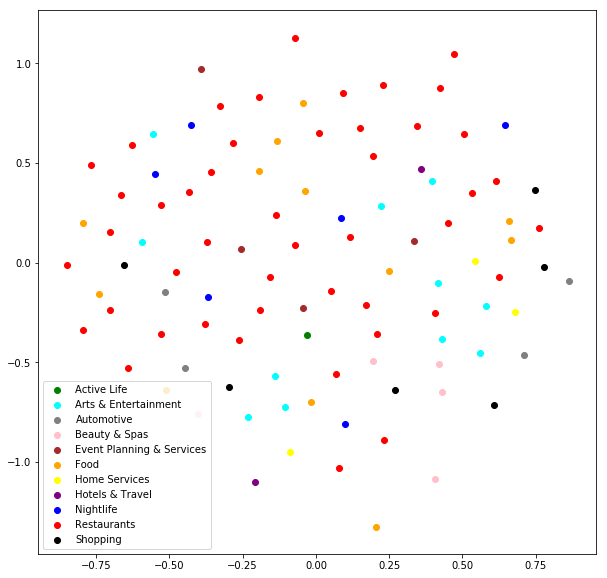

In [120]:
plt.figure(figsize=(10, 10))
for name, group in scaledGrouped:    
    plt.scatter(group[0], group[1], color = colorDict[name], label = name)    
    plt.legend(loc = 'best')